In [16]:
import pandas as pd
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.0.0


In [17]:
train_dataset = pd.read_csv('PredictiveMaintenanceEngineTraining.csv')
train_dataset = train_dataset.drop(columns=['label1', 'label2', 'cycle_norm', 'id', 'cycle', 's1','s5','s16','s18', 's19', 'setting3','s10'])
train_dataset.head(4)

,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188


Some rows are not relevant, some rows are always 0.

In [18]:
test_dataset = pd.read_csv('PredictiveMaintenanceEngineValidation.csv')
test_dataset = test_dataset.drop(columns=['label1', 'label2', 'cycle_norm', 'id', 'cycle', 's1','s5','s16','s18', 's19', 'setting3','s10'])
test_dataset.head(4)

,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,0.632184,0.750000,0.545181,0.310661,0.269413,1.0,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,0.344828,0.250000,0.150602,0.379551,0.222316,1.0,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,0.517241,0.583333,0.376506,0.346632,0.322248,1.0,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,0.741379,0.500000,0.370482,0.285154,0.408001,1.0,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139


In [19]:
train_labels = train_dataset.pop('RUL')
test_labels = test_dataset.pop('RUL')

In [20]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [21]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.12114251],
       [-0.09686701],
       [-0.08973164],
       [-0.19613492],
       [-0.0905072 ],
       [-0.08177342],
       [-0.11702825],
       [-0.09328756],
       [-0.09395745],
       [-0.00054161]], dtype=float32)

In [22]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................

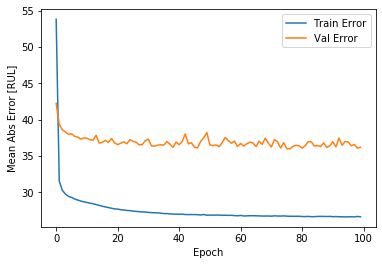

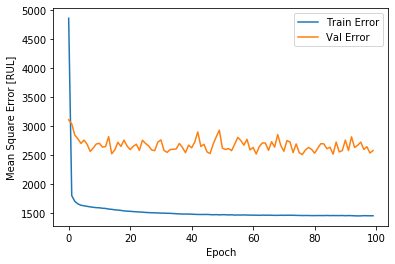

In [23]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [RUL]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [RUL]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [24]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} RUL".format(mae))

13096/13096 - 0s - loss: 2043.9659 - mae: 34.0009 - mse: 2043.9659
Testing set Mean Abs Error: 34.00 RUL


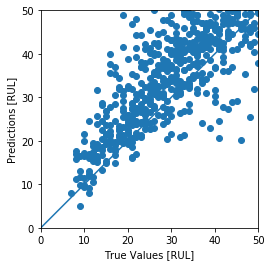

In [25]:
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [RUL]')
plt.ylabel('Predictions [RUL]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)